In [71]:
import pandas as pd
import numpy as np
from composition_stats import closure, clr, ilr

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel, SelectKBest

In [72]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

In [73]:
NONFS_GRID = {
    'RandomForest': {
        'n_estimators': [200, 300, 400],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [None, 3, 5, 7, 8]
    },
    'KNN': {
        'classifier__n_neighbors': [7, 9, 11, 13, 15, 17, 19, 21],
        'classifier__weights': ['uniform', 'distance']
    },
    'SVM': {
        'C': [0.001, 0.1, 1, 10, 100, 1000],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto']
    },
    'LogisticRegression': {
        'C': np.logspace(-4, 4, 20),
    },
    'Boosting': {'max_depth': [3, 5, 7, 8], 'n_estimators': [300, 500, 800]}

}

## Feature Selection

In [74]:
from mrmr_feature_selector import MRMRFeatureSelector
from sklearn.linear_model import Lasso

In [75]:
df2 = pd.read_csv("PAR2.csv")
df3 = pd.read_csv("PAR3.csv")
y2 = df2["label"]
df2.drop("label", axis=1, inplace=True)   
y3 = df3["label"]
df3.drop("label", axis=1, inplace=True)  
taxa2 = pd.read_csv("taxaparkinson2.csv", index_col=0)
taxa3 = pd.read_csv("taxaparkinson3.csv", index_col=0)

label_encoder = LabelEncoder()
y2 = label_encoder.fit_transform(y2.squeeze())
label_encoder = LabelEncoder()
y3 = label_encoder.fit_transform(y3.squeeze())



In [76]:
df_combined = pd.concat([df2, df3], axis=0, join='outer')
df_combined = df_combined.fillna(0)

In [77]:
clr_combined = pd.DataFrame(clr(closure(df_combined+0.5)))
clr_combined.columns = df_combined.columns

In [78]:
clr_combined

,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCTGATACTGGCAAGCTTGAGTCTCGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACGAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCCTGCTAAGCTGCAACTGACATTGAGGCTCGAAAGTGTGGGTATCAAACAGG,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTGCGTAGGCTGTTTCGTAAGTCGTGTGTGAAAGGCGCGGGCTCAACCCGCGGACGGCACATGATACTGCGAGACTAGAGTAATGGAGGGGGAACCGGAATTCTCGGTGTAGCAGTGAAATGCGTAGATATCGAGAGGAACACTCGTGGCGAAGGCGGGTTCCTGGACATTAACTGACGCTGAGGCACGAAGGCCAGGGGAGCGAAAGGG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATGTCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCCTGCTAAGCTGCAACTGACATTGAGGCTCGAAAGTGTGGGTATCAAACAGG,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTGCGGCAAGTCTGATGTGAAAGCCCGGGGCTCAACCCCGGTACTGCATTGGAAACTGTCGTACTAGAGTGTCGGAGGGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGATAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGTGTGGGTAGCAAACAGG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGATTGTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGCAGTCTTGAGTGCAGTAGAGGTGGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCTCACTGGAGTGTAACTGACGCTGATGCTCGAAAGTGTGGGTATCAAACAGG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGACGCTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGGTGTCTTGAGTACAGTAGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCTTGCTGGACTGTAACTGACGCTGATGCTCGAAAGTGTGGGTATCAAACAGG,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGGTTGTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGCGACCTTGAGTGCAACAGAGGTAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCTTACTGGATTGTAACTGACGCTGATGCTCGAAAGTGTGGGTATCAAACAGG,...,TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTGCGTAGGCGGCTAGACAAGTCAGGTGTGAAATACAGCAGCTCAACTGCGGGGCTGCACTTGAAACTGTAGAGCTTGAGTGATGGAGAGGTAAGCGGAATTCCTAGTGTAGCGGTAAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACATTAACTGACGCTGAGGCACGAAAGCGTGGGGAGCAAACAGG,GACAGAGGGTGCAAGCGTTGTTCGGAATCATTGGGCGTAAAGGGCGCGTAGGCGGTTTGGTAAGTCAGATGTGAAAGCCCAGGGCTCAACCTTGGAAGTGCATCTGAAACTACTGAACTAGAGTATCGGAGAGGGTGGTGGAATTCCCAGTGTAGAGGTGAAATTCGTAGATATTGGGAGGAACACCGGTGGCGAAGGCGGCCCCCTGGACGAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGG,TACGTATGTCCCGAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGACGGTTGGTTAAGTCTGATGTGAAAGCCCGGAGCTCAACTCCGGAAAGGCATTGGAAACTGGTTAACTTGAGTGCAGTAGAGGTAAGTGGAACTCCATGTGTAGCGGTGGAATGCGTAGATATATGGAAGAACACCAGCGGCGAAGGCGGCTTACTGGACTGTAACTGACGTTGAGGCTCGAAAGTGTGGGTAGCAAACAGG,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGGCGGCTTTGCAAGTCAGATGTGAAATCTATGGGCTCAACCCATAAACTGCATTTGAAACTGTCGTACTAGAGTGTCGGAGGGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGATAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,TACGGAGAATGCGAGCGTTATCCGGAATTATTGGGTTTAAAGGGTGCGTAGGTTGCAAGGGAAGTCAGGGGTGAAAAGCTGTAGCTCAACTATGGTCTTGCCTTTGAAACTCTCTAGCTAGAGTGTACTGGAGGTACGTGGAACGTGTGGTGTAGCGGTGAAATGCATAGATATCACACAGAACTCCGATTGCGCAGGCAGCGTACTACATTACAACTGACACTGAAGCACGAAAGCGTGGGTATCAAACAGG,TACGGAGGATCCGAGCGTTATCCGGAATTACTGGGCGTAAAGGGCGCGTAGGCGGTGTTTCAAGTCGTTCGTTAAATATTGAGGCTTAACCTCAAGGAGCGGCCGAAACTGAGACACTGGAGACACAGAGAGGCAAACAGAATTCCTGGTGTAGCGGTGAAATGCGTAGATATCAGGAAGAATAC

In [79]:
from matplotlib import pyplot as plt
import seaborn as sns

In [80]:
len(list(set(taxa2.index).intersection(set(taxa3.index))))

2360

In [81]:
taxa = pd.concat([taxa2, taxa3]).loc[~pd.concat([taxa2, taxa3]).index.duplicated(keep='first')]

## Cross Cohort

In [82]:
models = {
    'LogisticRegression': LogisticRegression(random_state=42), 
}

In [83]:
df_inter = pd.concat([df2, df3], axis=0, join='inner')

In [84]:
df2_inter = pd.DataFrame(clr(closure(df2.loc[:, df_inter.columns]+0.5)))
df2_inter.columns = df_inter.columns

In [85]:
df3_inter = pd.DataFrame(clr(closure(df3.loc[:, df_inter.columns]+0.5)))
df3_inter.columns = df_inter.columns

In [86]:
sel3 = MRMRFeatureSelector(num_features=100)
res3 = sel3.fit_transform(df3_inter, y3)

100%|██████████| 100/100 [00:12<00:00,  7.73it/s]


In [87]:
sel2 = MRMRFeatureSelector(num_features=100)
res2 = sel2.fit_transform(df2_inter, y2)

100%|██████████| 100/100 [00:12<00:00,  7.78it/s]


In [88]:
results_p3_mrmr_pruebafinal = []

In [89]:
for i in np.arange(2, 102, 2):
    lr = models["LogisticRegression"]
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(estimator=lr, param_grid=NONFS_GRID["LogisticRegression"], cv=inner_cv, scoring='roc_auc', refit=True, n_jobs=-1, verbose=1)
    grid.fit(df2_inter.loc[:, res2.columns[:i]], y2)
    results_p3_mrmr_pruebafinal.append(roc_auc_score(y3, grid.predict_proba(df3_inter.loc[:, res2.columns[:i]])[:, 1]))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 

In [90]:
results_p2_mrmr_pruebafinal = []

In [91]:
for i in np.arange(2, 102, 2):
    lr = models["LogisticRegression"]
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(estimator=lr, param_grid=NONFS_GRID["LogisticRegression"], cv=inner_cv, scoring='roc_auc', refit=True, n_jobs=-1, verbose=1)
    grid.fit(df3_inter.loc[:, res3.columns[:i]], y3)
    results_p2_mrmr_pruebafinal.append(roc_auc_score(y2, grid.predict_proba(df2_inter.loc[:, res3.columns[:i]])[:, 1]))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 

In [92]:
lasso2 = SelectFromModel(Lasso(alpha=0.01), max_features=100)

reslasso2 = lasso2.fit_transform(df2_inter, y2)
feature_importance = np.abs(lasso2.estimator_.coef_)
feature_ranking = pd.DataFrame({'Feature': df2_inter.columns, 'Importance': feature_importance})
feature_ranking = feature_ranking.sort_values(by='Importance', ascending=False)
top_features2 = feature_ranking.head(100)

In [93]:
results_p3_lasso_pruebafinal = []

In [94]:
for i in np.arange(2, 102, 2):
    lr = models["LogisticRegression"]
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(estimator=lr, param_grid=NONFS_GRID["LogisticRegression"], cv=inner_cv, scoring='roc_auc', refit=True, n_jobs=-1, verbose=1)
    grid.fit(df2_inter.loc[:, top_features2.Feature[:i]], y2)
    results_p3_lasso_pruebafinal.append(roc_auc_score(y3, grid.predict_proba(df3_inter.loc[:, top_features2.Feature[:i]])[:, 1]))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 

In [95]:
lasso3 = SelectFromModel(Lasso(alpha=0.01), max_features=100)

reslasso3 = lasso3.fit_transform(df3_inter, y3)
feature_importance = np.abs(lasso3.estimator_.coef_)
feature_ranking = pd.DataFrame({'Feature': df3_inter.columns, 'Importance': feature_importance})
feature_ranking = feature_ranking.sort_values(by='Importance', ascending=False)
top_features3 = feature_ranking.head(100)

In [96]:
results_p2_lasso_pruebafinal = []

In [97]:
for i in np.arange(2, 102, 2):
    lr = models["LogisticRegression"]
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(estimator=lr, param_grid=NONFS_GRID["LogisticRegression"], cv=inner_cv, scoring='roc_auc', refit=True, n_jobs=-1, verbose=1)
    grid.fit(df3_inter.loc[:, top_features3.Feature[:i]], y3)
    results_p2_lasso_pruebafinal.append(roc_auc_score(y2, grid.predict_proba(df2_inter.loc[:, top_features3.Feature[:i]])[:, 1]))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 

In [98]:
import matplotlib.pyplot as plt

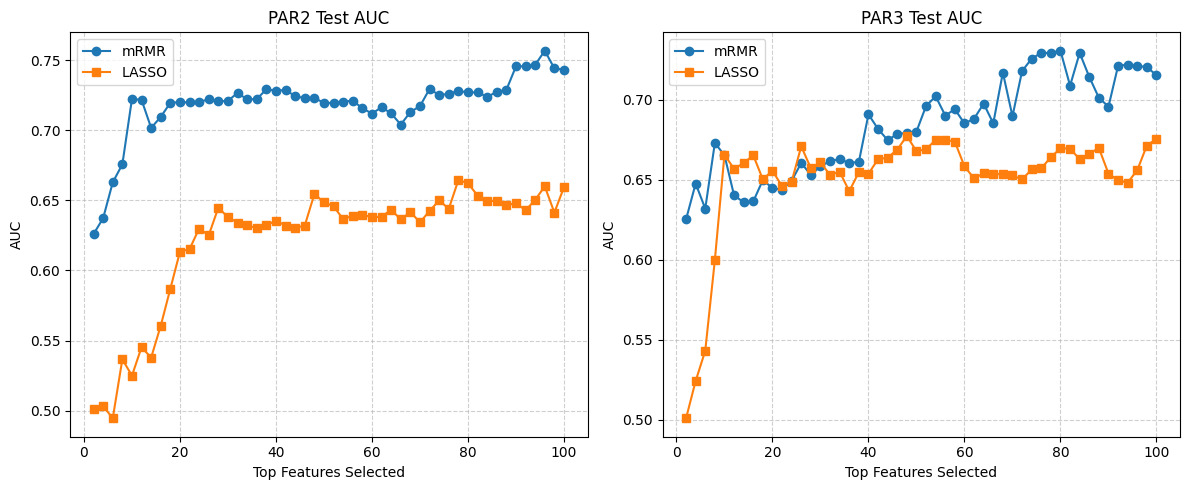

In [99]:
# Crear figura y subgráficas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
x_values = np.arange(2, 102, 2)
# Gráfica PARKINSON2
axes[0].plot(x_values, results_p2_mrmr_pruebafinal, label='mRMR', marker='o')
axes[0].plot(x_values, results_p2_lasso_pruebafinal, label='LASSO', marker='s')
axes[0].set_title("PAR2 Test AUC")
axes[0].set_xlabel("Top Features Selected")
axes[0].set_ylabel("AUC")
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend()

# Gráfica PARKINSON3
axes[1].plot(x_values, results_p3_mrmr_pruebafinal, label='mRMR', marker='o')
axes[1].plot(x_values, results_p3_lasso_pruebafinal, label='LASSO', marker='s')
axes[1].set_title("PAR3 Test AUC")
axes[1].set_xlabel("Top Features Selected")
axes[1].set_ylabel("AUC")
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend()

# Ajustar diseño
plt.tight_layout()
plt.savefig("test_auc_parkinson.png", dpi=300, bbox_inches='tight')

In [100]:
len(set(res3.columns).intersection(set(top_features3.Feature)))

29

In [101]:
len(set(res3.columns[:20]).intersection(set(top_features3.Feature[:20])))

4

In [102]:
len(set(res3.columns[:50]).intersection(set(top_features3.Feature[:50])))

12

In [103]:
len(set(res3.columns).intersection(set(res2.columns)))

18

In [104]:
inter = list(set(res3.columns).intersection(set(res2.columns)))

In [105]:
len(set(res3.columns[:50]).intersection(set(res2.columns[:50])))

6

In [106]:
taxa2.loc[inter]

,Kingdom,Phylum,Class,Order,Family,Genus,Species
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTGCGGCAAGTCTGATGTGAAAGCCCGGGGCTCAACCCCGGTACTGCATTGGAAACTGTCGTACTAGAGTGTCGGAGGGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGATAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Agathobacter,NaN
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGATGGACAAGTCTGATGTGAAAGGCTGGGGCTCAACCCCGGGACTGCATTGGAAACTGCCCGTCTTGAGTGCCGGAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Blautia,massiliensis
TACGTAGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCACGTCGTCTGTGAAATCCTAGGGCTTAACCCTGGACGTGCAGGCGATACGGGCTGACTTGAGTACTACAGGGGAGACTGGAATTTCTGGTGTAGCGGTGGAATGCACAGATATCAGGAAGAACACCGATGGCGAAGGCAGGTCTCTGGGTAGTAACTGACGCTGAGGAGCGAAAGCATGGGTAGCGAACAGG,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Corynebacteriaceae,Lawsonella,clevelandensis
TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGTGCAGGCGGTTCAATAAGTCTGATGTGAAAGCCTTCGGCTCAACCGGAGAATTGCATCAGAAACTGTTGAACTTGAGTGCAGAAGAGGAGAGTGGAACTCCATGTGTAGCGGTGGAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTCTCTGGTCTGCAACTGACGCTGAGGCTCGAAAGCATGGGTAGCGAACAGG,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,crispatus/gasseri/helveticus/hominis/iatae/joh...
TACGTAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCTCGTAGGCGGTTCGTCGCGTCCGGTGTGAAAGTCCATCGCTTAACGGTGGATCTGCGCCGGGTACGGGCGGGCTGGAGTGCGGTAGGGGAGACTGGAATTCCCGGTGTAACGGTGGAATGTGTAGATATCGGGAAGAACACCAATGGCGAAGGCAGGTCTCTGGGCCGTTACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACAGG,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,catenulatum/gallicum/kashiwanohense/pseudocate...
TACGTAGGTGGCGAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGTGTAGGCGGGAAGGCAAGTCAGAAGTGAAAATTATGGGCTTAACCCATAACCTGCTTTTGAAACTGTTTTTCTTGAGTGAGGCAGAGGCAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTGCTGGGCCTTTACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminiclostridium_6,NaN
TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGGGAACGCAGGCGGTCTTTTAAGTCTGATGTGAAAGCCTTCGGCTTAACCGGAGTAGTGCATTGGAAACTGGAAGACTTGAGTGCAGAAGAGGAGAGTGGAACTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAAGAACACCAGTGGCGAAAGCGGCTCTCTGGTCTGTAACTGACGCTGAGGTTCGAAAGCGTGGGTAGCAAACAGG,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,phage/reuteri/salivarius
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGTCAAGCAAGTCAGAAGTGAAAGGCTGGGGCTCAACCCCGGGACTGCTTTTGAAACTGTTTGACTGGAGTGCTGGAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACAGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,NaN
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGACGCAAGTCTGAAGTGAAATACCCGGGCTCAACCTGGGAACTGCTTTGGAAACTGTGTTGCTAGAGTGCTGGAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAAGAACACCAGTGGCGAAGGCGGCTTACTGGACAGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_UCG-004,NaN
TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTTGTTAAGTTGAATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCCAAAACTGGCAAGCTAGAGTATGGTAGAGGGTAGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACTACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,deceptionensis/endophytica/fluorescens/fragi/h...


In [107]:
taxa2.loc[list(set(res3.columns[:50]).intersection(set(res2.columns[:50])))]

,Kingdom,Phylum,Class,Order,Family,Genus,Species
TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGTGCAGGCGGTTCAATAAGTCTGATGTGAAAGCCTTCGGCTCAACCGGAGAATTGCATCAGAAACTGTTGAACTTGAGTGCAGAAGAGGAGAGTGGAACTCCATGTGTAGCGGTGGAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTCTCTGGTCTGCAACTGACGCTGAGGCTCGAAAGCATGGGTAGCGAACAGG,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,crispatus/gasseri/helveticus/hominis/iatae/joh...
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTACGGCAAGTCTGATGTGAAAGCCCGGGGCTCAACCCCGGTACTGCATTGGAAACTGTCGGACTAGAGTGTCGGAGGGGTAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGATTACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,intestinalis
TACGTAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCTCGTAGGCGGTTCGTCGCGTCCGGTGTGAAAGTCCATCGCTTAACGGTGGATCCGCGCCGGGTACGGGCGGGCTTGAGTGCGGTAGGGGAGACTGGAATTCCCGGTGTAACGGTGGAATGTGTAGATATCGGGAAGAACACCAATGGCGAAGGCAGGTCTCTGGGCCGTCACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACAGG,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,adolescentis/faecale/longum/stercoris
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGTGTGGCAAGTCTGATGTGAAAGGCATGGGCTCAACCTGTGGACTGCATTGGAAACTGTCATACTTGAGTGCCGGAGGGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Blautia,obeum/provencensis/wexlerae
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGGTGGCAAGGCAAGCCAGAAGTGAAAACCCGGGGCTCAACCGCGGGATTGCTTTTGGAACTGTCATGCTAGAGTGCAGGAGGGGTGAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCGGAGGCGAAGGCGGCTCACTGGACTGTAACTGACACTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_ND3007_group,NaN
TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGGGAGCGCAGGCGGTCAGGAAAGTCTGGAGTAAAAGGCTATGGCTCAACCATAGTGTGCTCTGGAAACTGTCTGACTTGAGTGCAGAAGGGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCAGTGGCGAAAGCGGCTCTCTGGTCTGTCACTGACGCTGAGGCTCGAAAGCGTGGGTAGCGAACAGG,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,mutans


In [108]:
taxa2.loc[sel2.selected_features]

,Kingdom,Phylum,Class,Order,Family,Genus,Species
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGTGTGGCAAGTCTGATGTGAAAGGCATGGGCTCAACCTGTGGACTGCATTGGAAACTGTCATACTTGAGTGCCGGAGGGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Blautia,obeum/provencensis/wexlerae
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGCAGGGCAAGTCAGATGTGAAAGCCCGGGGCTCAACCCCGGGACTGCATTTGAAACTGTCCAGCTGGAGTACAGGAGAGGCAGGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCCTGCTGGACTGTAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4B4_group,NaN
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGCCAGGTAAGCGTGTTGTGAAATGTACCGGCTCAACCGGTGAATTGCAGCGCGAACTGTCTGGCTTGAGTGCACGGTAAGCAGGCGGAATTCATGGTGTAGCGGTGAAATGCTTAGATATCATGAAGAACTCCGATTGCGAAGGCAGCTTGCTGCAGTGCGACTGACGCTGATGCTCGAAGGTGCGGGTATCAAACAGG,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,buccalis
TACGTAGGGAGCAAGCGTTATCCGGATTTATTGGGTGTAAAGGGTGCGTAGGCGGTTTATTAGGTCTATGGTTTAATTCCGAAGCTTAACTTCGGTTCGCCATAGAAACCGATTTACTTGAGTATGGTAGAGGCAAGTGGAATTTCTAGTGTAGCGGTAAAATGCGTAGATATTAGAAGGAACACCAGTGGCGAAGGCGACTTGCTGGGCCATCACTGACGCTGAGGCACGAAAGCGTGGGGAGCAAATAGG,Bacteria,Tenericutes,Mollicutes,Mollicutes_RF39,NaN,NaN,NaN
TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCGGATTTTTAAGTGAGATGTGAAATACTCGGGCTTAACCTGAGTGCTGCATTTCAAACTGGAAGTCTAGAGTGCAGGAGAGGAGAAGGGAATTCCTAGTGTAGCGGTGAAATGCGTAGAGATTAGGAAGAACACCAGTGGCGAAGGCGCTTCTCTGGACTGTAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae_1,Clostridium_sensu_stricto_1,NaN
...,...,...,...,...,...,...,...
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGTTAAGCAAGTCTGAAGTGAAAGCCCGGGGCTCAACCCCGGTACTGCTTTGGAAACTGTTTGACTTGAGTGCAGGAGAGGTAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACTGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Hungatella,effluvii/hathewayi
TACGTAGGTGGCGAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGAGTAGGCGGGAAGTCAAGTCAGATGTGAAATGCCGCGGCTTAACTGCGGAACTGCATTTGAAACTGATTTTCTTGAGAGTCGGAGAGGCAATCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGATTGCTGGACGACAACTGACGCTGAGACACGAAAGCGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,NaN,NaN
TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTTGTTAAGTTGAATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCCAAAACTGGCAAGCTAGAGTATGGTAGAGGGTAGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACTACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,deceptionensis/endophytica/fluorescens/fragi/h...
TACGTAGGTGACAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGCGTAGGCGGACTGTCAAGTCAGTCGTGAAATACCGGGGCTTAACCCCGGGGCTGCGATTGAAACTGACAGCCTTGAGTATCGGAGAGGAAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTTCTGGACGACAACTGACGCTGAGGCGCGAAAGTGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae_UCG-013,NaN


In [109]:
taxa3.loc[sel3.selected_features]

,Kingdom,Phylum,Class,Order,Family,Genus,Species
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTACGGCAAGTCTGATGTGAAAGCCCGGGGCTCAACCCCGGTACTGCATTGGAAACTGTCGGACTAGAGTGTCGGAGGGGTAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGATTACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,intestinalis
TACGGAGGATCCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTTTGATAAGTTAGAGGTGAAAGCTCGGGGCTTAACTCCGAGACTGCCTCTAATACTGTTGAGCTAGAGAGTAGTTGCGGTAGGCGGAATGTATGGTGTAGCGGTGAAATGCGTAGAGATCATACAGAACACCGATTGCGAAGGCAGCTTACCAAACTATATCTGACGTTGAGGCACGAAAGCGTGGGGAGCAAACAGG,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,NaN
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGAAGCTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGGTTTCTTGAGTGCAGTAGAGGTAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCTTACTGGACTGTAACTGACGCTGATGCTCGAAAGTGTGGGTATCAAACAGG,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,oleiciplenus/stercorirosoris
TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGGGAGCGCAGGCGGTCAGGAAAGTCTGGAGTAAAAGGCTATGGCTCAACCATAGTGTGCTCTGGAAACTGTCTGACTTGAGTGCAGAAGGGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCAGTGGCGAAAGCGGCTCTCTGGTCTGTCACTGACGCTGAGGCTCGAAAGCGTGGGTAGCGAACAGG,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,mutans
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTGGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Klebsiella,NaN
...,...,...,...,...,...,...,...
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGATAGGCAAGTCTGAAGTGAAAGCCCGGGGCTCAACCCCGGGACTGCTTTGGAAACTGTTTATCTAGAGTGCTGGAGAGGTAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACAGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,NaN
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTGCGGCAAGTCTGATGTGAAAGCCCGGGGCTCAACCCCGGTACTGCATTGGAAACTGTCGTACTAGAGTGTCGGAGGGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGATAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Agathobacter,NaN
TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGTGGTTTAATAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGTTAAACTTGAGTGCAGGAGAGAAAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGAGATTAGGAGGAACACCAGTGGCGAAGGCGGCTTTTTGGCCTGTAACTGACACTGAGGCGCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Bacilli,Bacillales,Family_XI,Gemella,haemolysans/morbillorum/parahaemolysans/sangui...
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGACGGCAATGCAAGTCTGAAGTGAAAGCCCGGGGCTCAACCCCGGTACTGCTTTGGAAACTGTATAGCTAGAGTACTGGAGAGGCAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTGCTGGACAGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,NaN
